## Introduction
In this notebook we will introduce computationally efficient 2D numerical models that can model radially-symmetric flow and transport within vertically heterogeneous systems. Severally formulations have been proposed to model radially symmetric flow conditions as nicely summarized by [Wallis et al, 2013](10.1111/j.1745-6584.2012.00978.x). The approach in this notebook is based on the formulation originally proposed by [Louwyck et al, 2012](https://www.sciencedirect.com/science/article/pii/S0098300411003049?via%3Dihub). 

If you haven't installed or worked through a FloPy model, go back to the [FloPy Introduction notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%20Introduction.ipynb).

Begin by importing the standard libraries

In [489]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
import time
import warnings
# In addition to our typical libraries
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as deepcopy
# Import some mathematical expressions for analytical solution calculations
from scipy.special import erfc as erfc
from scipy.special import expi as expi
from math import pi
from math import factorial

First find where you have your MODFLOW and MT3D executables located on your system. Note that you need to include the path if the executables are not in the current directory.

In [490]:
## DELL 419 PATHS
# # Path to MODFLOW executable, probably called 'mf2005'
# exe_mf = 'D:\\Dropbox\\Research\\Simulation\\modflow\\executables\\mf2005'
# # Path to MT3D-USGS executable, probably called 'mt3dms'
# exe_mt = 'D:\\Dropbox\\Research\\Simulation\\modflow\\executables\\mt3dms'

## LAPTOP PATHS
# Path to MODFLOW executable, probably called 'mf2005'
exe_mf = 'C:\\Hydro\\MF2005.1_12\\bin\\mf2005'
# Path to MT3D-USGS executable, probably called 'mt3dms'
exe_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'

# Print to make sure it is formated correctly
print(exe_mf)
# Print to make sure it is formated correctly
print(exe_mt)

C:\Hydro\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Check these paths. Do they look correct for your system? If not this will lead to errors later.

Now lets name the folder(s) where we want will save our model.  

In [491]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Notebooks_unpublished


In [492]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
# os.chdir('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises')
# current_directory = os.getcwd()
# print(current_directory)

In [493]:
# now lets give a name to the directory to save data, this directory should be present in your 
# current working directory (but if it's not don't worry!)
directory_name = 'wallis_radial'
# Let's add that to the path of the current directory
workdir = os.path.join('.', directory_name)

# if the path exists then we will move on, if not then create a folder with the 'directory_name'
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
print("Directory '% s' created" % workdir) 
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')

Directory '.\wallis_radial' created


Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.

## 2D plot function
Since we are going to be plotting a lot of results in 2D it will be useful to define a function that can easily plot 2D maps. The utility of this function will be demonstrated in the next few cells.

In [494]:
def plot_2d(map_data, rj_edges, ri_edges, colorbar_label='', cmap='cividis', title='', clim=0):    
    # Use 'pcolormesh' function to plot 2d map of concentration
    plt.figure(figsize=(12, 2), dpi=150)
    plt.pcolormesh(rj_edges, ri_edges, np.squeeze(map_data), cmap=cmap, shading = 'flat', edgecolor ='k', linewidth = 0.01)
    # plt.gca().set_aspect('equal')  
    # add a colorbar
    cbar = plt.colorbar() 
    # label the colorbar
    cbar.set_label(colorbar_label)
    if clim != 0:
        plt.clim(clim)
    plt.xlabel('Distance [m]')
    plt.tick_params(axis='both', which='major')
    plt.xlim((np.min(rj_edges), np.max(rj_edges))) 
    plt.ylim((np.min(ri_edges), np.max(ri_edges)))
    plt.title(title)
    plt.show()

## 2D radial model discretization and parameter scaling 
This is based on the Louwyck method that has aquifer parameters scaled on the basis of a radial grid consisting of a series of nc concentric rings with radii rj around a well.

In [495]:
def log_radial_homogeneous_model_disc(rin, rout, n):
    # Using equation 2 from Louwyck et al, 2014 (10.1007/s10040-014-1150-0)
    alpha = (np.log(rout) - np.log(rin))/n
    k = np.arange(n+1)
    # cell edges
    rj_edges = np.exp(np.log(rin) + k*alpha)
    # cell centers
    rj = (rj_edges[1:]*rj_edges[:-1])**(1/2)
    # grid cell size radially from well
    delr = np.diff(rj_edges)
    return rj_edges, rj


def log_radial_model_disc(r0, ar, n):
    # 1d log louwyck (Table 1)
    # cell centers calculated directly
    rj = r0*ar**np.arange(0, n)
    rjm05 = rj*ar**(-0.5)
    rjp05 = rj*ar**(0.5)
    rj_edges = np.append(rjm05, rjp05[-1])
    return rj_edges, rj


def wallis_radial_model_disc(r0, ar, dr_max, rwell, n):
    # Using equation 2 from Louwyck et al, 2014 (10.1007/s10040-014-1150-0)
    delr = r0*ar**np.arange(1, n)
    delr = np.insert(delr, 0, rwell)
    # set cells wider than 5 meters equal to 5
    delr[delr>dr_max]=dr_max
    # from this we can calculate the r_j+0.5 using a cumulative sumation and adding 1 to account for the 1 meter wide well cell
    rjp05 = np.cumsum(delr)
    rj_edges = np.insert(rjp05, 0, 0)
    # cell centers
    rj = (rj_edges[1:]*rj_edges[:-1])**(1/2)
    print('number of gridcells in radial direction = ' + str(len(rj)))
    print('maximum distance from well = ' + str(rj_edges[-1]))
    return rj_edges, rj
    

number of gridcells in radial direction = 250
maximum distance from well = 1165.0637708406757


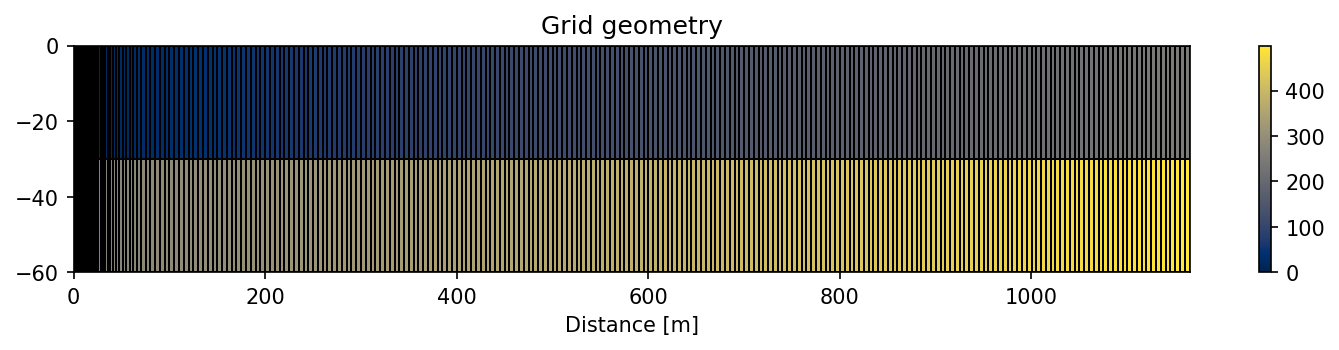

In [496]:
# Model discretization
nrow = 1 # one row orthogonal to 2D plane
nlay = 2
# ncol = 120 # 'nc' concentric rings
ncol = 250
model_thickness = 60 # [meters]

rwell = 1
r0 = rwell
ar = 1.05
dr_max = 5 # [m]

rj_edges, rj = wallis_radial_model_disc(r0, ar, dr_max, rwell, ncol)
# r0=0.5
# ar = 1.086
# rj_edges, rj = log_radial_model_disc(r0, ar, nrow)
# print(rj_edges)

# define other grid characteristics
delc = 1 # grid size in direction of Y (I) axis, 
delv = model_thickness/nlay # grid size in direction of Z (K) axis
# define vertical grid
ri_edges = np.linspace(0, model_thickness, nlay + 1)

# define some arbitrary z values for plotting grid
Z = np.arange(ncol * nlay).reshape(nlay, ncol)

plot_2d(Z, rj_edges, -ri_edges, cmap='cividis', title='Grid geometry')

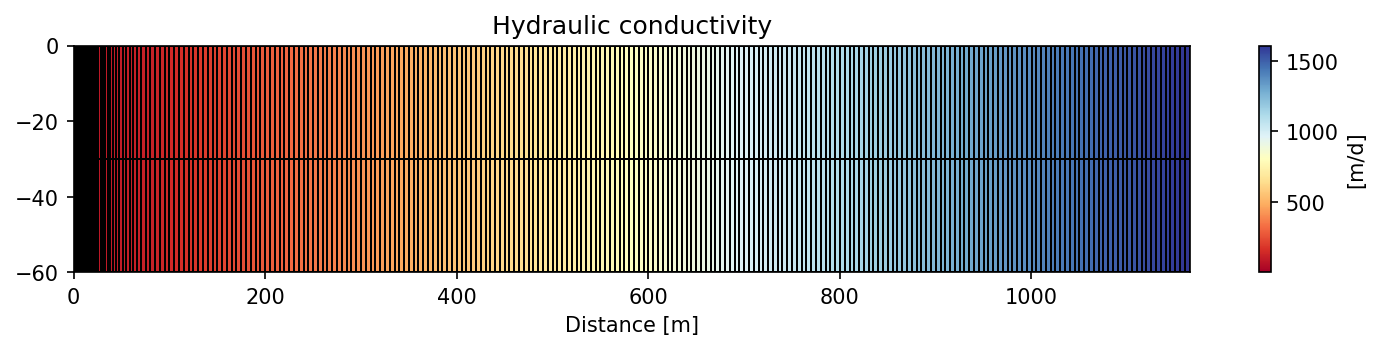

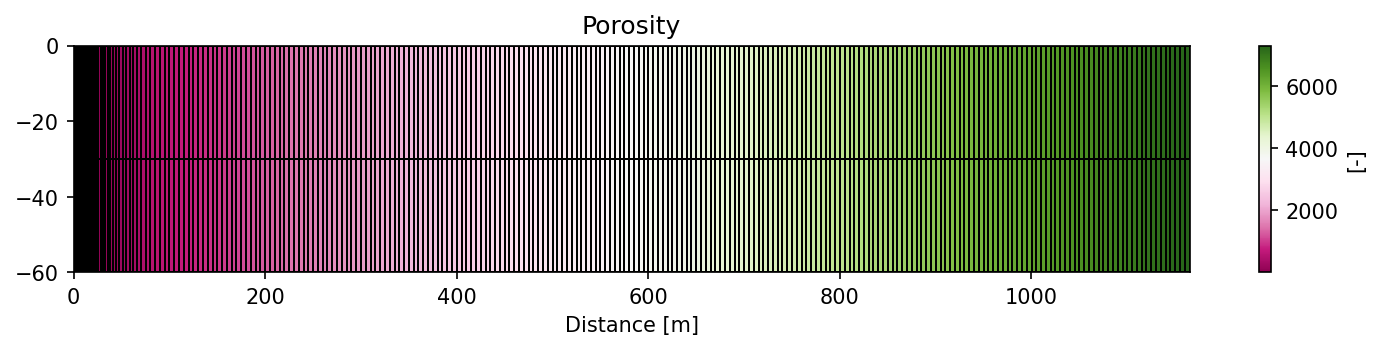

In [497]:
# Mt Simon
kh = 1.1 # [m/day]
# kz = 0.006 # [m/day]
kz = kh
# Eau Claire
# Kh = 0.72 # [m/day]
# Ky = 0.0012 # [m/day]
porosity = 0.2
alpha_L = 1

# assign layer hk
HK_layers = np.array([kh, kh])
# scale hydraulic conductivity across radial model
HK = np.outer(HK_layers, (2*pi/(np.log(rj_edges[1:]/rj_edges[:-1]))))
HK[:,0] = HK_layers
HK = np.reshape(HK, (nlay, nrow, ncol))


def surface_area_scaling_radially(var_layer, rj_edges):
    VAR = np.outer(var_layer, pi*(rj_edges[1:]**2- rj_edges[:-1]**2))
    VAR[:,0] = var_layer
    var_size = VAR.shape
    VAR = np.reshape(VAR, (var_size[0], 1, var_size[1]))
    return VAR

# assign layer hk
VKA_layers = np.ones(nlay)*kz
# scale vertcal hydraulic conductivity across radial model
VKA = surface_area_scaling_radially(VKA_layers, rj_edges)

# specific yield
sy_default = 0.15 # (default is 0.15)
# scale specific yield across radial model
SY = surface_area_scaling_radially(np.ones(nlay)*sy_default, rj_edges)

# porosity
Por_layers = np.array([porosity, porosity])
POR = surface_area_scaling_radially(Por_layers, rj_edges)
POR = np.reshape(POR, (nlay, nrow, ncol))

AL = np.outer(np.ones(nlay)*alpha_L, 1/(rj_edges[1:]- rj_edges[:-1]))
AL = np.reshape(AL, (nlay, nrow, ncol))

plot_2d(HK, rj_edges, -ri_edges, colorbar_label='[m/d]', title='Hydraulic conductivity', cmap='RdYlBu')
plot_2d(POR, rj_edges, -ri_edges, colorbar_label='[-]', title='Porosity', cmap='PiYG')


## 2D Layered Radial Model 
The first thing we do is setup the function. The input variables are:

### Function Input:
#### directory name
    direname = 

#### MT3D period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). This is set equal to the MODFLOW flow model period input. For example:
 
    perlen_mt = [3, 4]
    
#### hydraulic conductivity
The hydraulic conductivity needs to be in the selected units (m/day in this model) and needs to be scaled as described in the previous cells.

#### dispersivity
Set the longitudinal dispersivity in meters. This also must be scaled radially.
    
#### vertical conductivity 
An array indicating the vertical conductivity between layers.

#### specific storage (SS) and specific yield (SY)
These two parameters only need to be defined if running an unsteady state model (otherwise set these to zero).


In [498]:
def radial_model_2D(dirname, perlen_mt, ri_edges, HK, POR, VKA, SS, SY, AL, Q, C_inj=None, Ci_layer=None, nprs=100, mixelm=1):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 4 # MODFLOW
    mt_tunit = 'D' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 2 # MODFLOW units
    mt_lunit = 'M' # MT3D units
    
    # Modflow stress periods
    perlen_mf = perlen_mt
    # number of stress periods (MF input), calculated from period length input
    nper_mf = len(perlen_mf)
    
    # number of stress periods (MT input), calculated from period length input
    nper = len(perlen_mt)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = nprs
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    hk_size = HK.shape
    nlay = hk_size[0] # number of layers
    nrow = hk_size[1] # number of rows
    ncol = hk_size[2] # number of columns
    delr = 1.0 # grid size in direction of Lx
    delc = 1.0 # grid size in direction of Ly, 
    botm = -ri_edges[1:]
    
    # ratio of vertical transverse dispersivity to longitudenal dispersivity
    trpv = 0.1
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    # index the model boundary cells
    ibound[:, :, -1] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    
    # Stress period well data for MODFLOW. Each well is defined through defintition
    # of layer (int), row (int), column (int), flux (float). The first number corresponds to the stress period
    # flux of water through well = volumetric flow rate divided by cross sectional area
    Qf =  Q/(delc*np.max(ri_edges))
    # cross sectional area of well cells
    Aw = np.diff(ri_edges)*delc
    # Example for 1 stress period: spd_mf = {0:[[0, 0, 1, q],[0, 5, 1, q]]}
    well_info = np.zeros((nlay, 4), dtype=float)
    # set indices of inlet face of column
    well_info[:,0] = range(0, nlay)
    # set volumetric flow rate
    # well_info[:,3] = Q[0]* 1/(delc*np.max(ri_edges))
    
    spd_mf={}
    for i in range(0, nper-1):
        for layer in range(0, nlay):
        
            if isinstance(Q, (list, tuple, np.ndarray)):
                # print(layer)
                # print(Qf[i])
                # print(Aw[layer])
                well_info[layer, 3] = Qf[i]*Aw[layer]
            else:
                well_info[layer, 3] = Qf*Aw[layer]
              
        # deep copy and insert into MODFLOW well dictionary
        w = deepcopy(well_info)
        spd_mf.update({i:w}) 
    
    # Solute transport boundary conditions
    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=int)
    # set outer model boundary to constant concentration or constant mass flux (default if a constant head boundary)
    # icbund[:, :, -1] = -1

    # Initial conditions: 
    # If Ci_layer is defined then apply concentration constant in a given layer
    if Ci_layer is not None:
        print('Ci_layer given as input')
        if isinstance(Ci_layer, (list, tuple, np.ndarray)):
            # first ensure that Ci_layer is the same size as the number of layers
            if len(Ci_layer) == nlay:
                sconc = np.outer(Ci_layer, np.ones((nrow, ncol)))
            else:
                warnings.warn('Layer concentrations are not equal to the number of model layers, assigning initial concentration of zero to entire model.')
                sconc = np.zeros((nlay, nrow, ncol))
        else: # if a scalar is given then apply it to entire model
            sconc = Ci_layer* np.ones((nlay, nrow, ncol))
                
    else: # initial concentration is zero
        print('Initial concentration input not given, initial concentration is zero everywhere')
        sconc = np.zeros((nlay, nrow, ncol))
    
    # MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
    # This is used as input for the source and sink mixing package
    # Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
    # if solute is being injected into well then apply stress period MT3D well dictionary
    # The current implementation assumes constant concentration injected along entire wellbore
    if C_inj is not None:
        if isinstance(C_inj, (list, tuple, np.ndarray)) and len(C_inj) != nper:
            warnings.warn('C_inj length different than number of stress periods so C_inj = C_inj[0] for all stress periods')
            C_inj = np.ones(nper)*C_inj[0]
        else:
            C_inj = np.ones(nper)*C_inj
            
        itype = 2
        cwell_info = np.zeros((nlay, 5), dtype=float)
        # set indices of inlet face of column
        cwell_info[:,0] = range(0, nlay)
        # set itype
        cwell_info[:,4] = itype
        # set injection concentration for first stress period
        cwell_info[:,3] = C_inj[0]
        # Nested loop to define every inlet face grid cell as a well
        spd_mt={0:deepcopy(cwell_info)}
        
        # Nested loop to define every inlet face grid cell as a well
        for i in range(1, nper):
            # print(C_inj[i])
            cwell_info[:,3] = C_inj[i]
            # deep copy into mt dictionary
            spd_mt.update({i:deepcopy(cwell_info)}) 
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf,
                                   delr=delr, delc=delc, top=0., botm= botm,
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni) # include steady =False for unsteady state flow model
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class (layavg flag must be set to 0 (default) to use harmonic mean calculation)
    # vka (float or array of floats (nlay, nrow, ncol)) – is either vertical hydraulic conductivity or the ratio of horizontal to vertical hydraulic conductivity depending on the value of LAYVKA. (default is 1.0).
    # ss (float or array of floats (nlay, nrow, ncol)) – is specific storage unless the STORAGECOEFFICIENT option is used. When STORAGECOEFFICIENT is used, Ss is confined storage coefficient. (default is 1.e-5).
    # sy (float or array of floats (nlay, nrow, ncol)) – is specific yield. (default is 0.15).
    # CHANI is less than or equal to 0, then variable HANI defines horizontal anisotropy.
    lpf = flopy.modflow.ModflowLpf(mf, hk=HK, laytyp=0, chani=-1, layavg=0, vka=VKA, ss=SS, sy=SY)
    # MODFLOW well package class
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd_mf)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    # MODFLOW output control package ##### NEEDS TO BE INCLUDED TO EXTRACT HEADS ###########
    # spd = {(0, 0): ['save head'], (0, 1): ['save head']}
    # oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)
    oc = flopy.modflow.ModflowOc(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=POR, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = mixelm
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    dsp = flopy.mt3d.Mt3dDsp(mt, al=AL, trpv =trpv)
    # if solute is being injected into well then apply stress period MT3D well dictionary
    if C_inj is not None:
        ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    else:
        ssm = flopy.mt3d.Mt3dSsm(mt)
    
    gcg = flopy.mt3d.Mt3dGcg(mt, cclose = 1e-10)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    # Extract head information. In order for this to work you must include 'oc = flopy.modflow.ModflowOc(mf)' before running mf model
    # if you pass the model instance, then the plots will be offset and rotated
    h = flopy.utils.HeadFile(os.path.join(model_ws, modelname_mf+'.hds'), model=mf)
    htimes = h.times
    fname = os.path.join(model_ws, modelname_mf+'.hds')
    hdobj = flopy.utils.HeadFile(fname)
    heads = hdobj.get_data()
    
    if len(times) != nprs+len(perlen_mt):
        print('The model output has {} timesteps, the model input requested {} timesteps. Simulation may have terminated early'.format(len(times), nprs+len(perlen_mt)))
    else:
        print('Simulation ran to requested model time.')
        
    return heads, htimes, conc, times

## 1D Radial Model Analytical Solutions
Let's first define a function for the analytical solution for conservative solute transport in a radial system. The analytical solution for radial transport is described in detail in [Gelhar and Collins, 1971](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/WR007i006p01511).

In [499]:
# Analytical solution (Gelhar and Collins, 1971) https://doi.org/10.1029/WR007i006p01511
def ADE_radial_fun(t, r, Q, dz, phi, alpha_L, D, S, C0, C_inj):
    A = Q/(2*pi*dz*phi) # equation 10 in Wallis 2012
    ri = (2*A*t)**(1/2) # equation 9 in Wallis
    # Note that the '\' means continued on the next line
    C = (C_inj-C0)*((1/2)*erfc((r**2 - ri**2)/(2*np.sqrt((4/S*alpha_L*ri**3)+ (D/A*ri**4))))) + C0
    # Return the concentration (C) from this function
    return C

# Thiem equation gives the analytical solution for steady state pumping in infinite aquifer. 
def Thiem_fun(r, r0, h0, Q, dz, hk):
    # transmissivity
    T = hk*dz # m/day * m = m^2/day
    # Thiem Equation
    h = -Q/(2*pi*T)*np.log(r/r0)+h0
    return h

# Theis equation gives the analytical solution for unsteady state pumping in infinite aquifer. Note that to compare to MODFLOW steady=False is required in flopy.modflow.ModflowDis class input. 
def Theis_fun(t, r, Q, dz, hk, S):
    # transmissivity
    T = hk*dz # m/day * m = m^2/day
    u = r**2 *S/(4*T*t) # dimensionless
    # Well function W(u)
    W = -expi(-u)
    # W = -0.5772-np.log(u)+ u- (u**2/(2*factorial(2))) + (u**3/(3*factorial(3))) - (u**4/(4*factorial(4)))
    dh = Q/(4*pi*T)*W
    return dh

## Numerical model - analytical model comparison

Ok, now we are ready to run some models! Let's first run the model with the homogeneous permeability field.

In [500]:
# Directory name
dirname = 'two_layer_test'
# Length of model run
perlen_mt = [3, 40]
# Negative Q is pumping, positive is injection
Q = 50

Ci_layer = 1.0
C_inj= 0.5

# specific storage
ss_default = 1.e-5 # (default)
# scale specific storage across radial model
SS = surface_area_scaling_radially(np.ones(nlay)*ss_default, rj_edges)

# RUN model! Note that if model is steady state then SS and SY can just be set to 0
heads, htimes, conc, times = radial_model_2D(dirname, perlen_mt, ri_edges, HK, POR, VKA, SS, SY, AL, Q, C_inj, Ci_layer, nprs=100, mixelm=1)


Ci_layer given as input
Simulation ran to requested model time.


Let's verify that the flow part of the model is working by comparing the flow model results with analytical solutions.

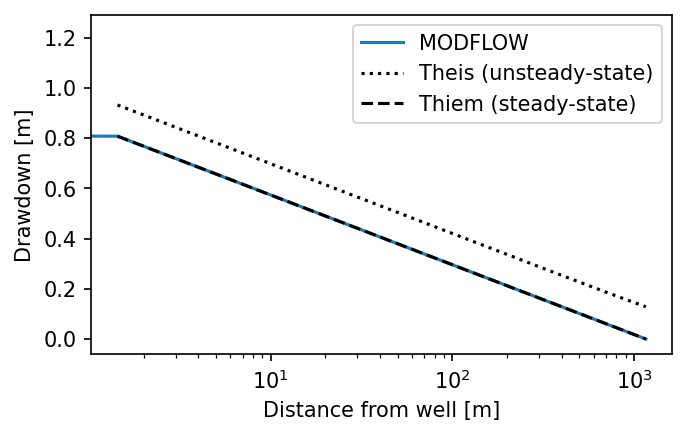

In [501]:
# storagetivity is the volume of water removed from a unit area of an aquifer for a unit drop in hydraulic head; in confined aquifers, it is equal to the specific storage times the thickness of the aquifer
S = model_thickness*ss_default

h_uss = Theis_fun(times[-1], rj, Q, model_thickness, kh, S)
h_ss = Thiem_fun(rj, rj[-1], 0, Q, model_thickness, kh)

plt.figure(figsize=(5, 3),dpi=150)
plt.plot(rj, np.squeeze(np.mean(heads, axis=0)), label = 'MODFLOW')
plt.plot(rj[1:], h_uss[1:], ':k', label = 'Theis (unsteady-state)')
plt.plot(rj[1:], h_ss[1:], '--k', label = 'Thiem (steady-state)')
plt.xscale('log')
plt.xlabel('Distance from well [m]')
plt.ylabel('Drawdown [m]')
plt.legend()
plt.show()

Depending on the pumping rates, storativity, scale of the model, and time of pumping the steady and steady state models might look very similiar or very different.

Now let's make sure that the concentration fields aren't doing anything weird. The right side of the model has a constant mass flux boundary condition.

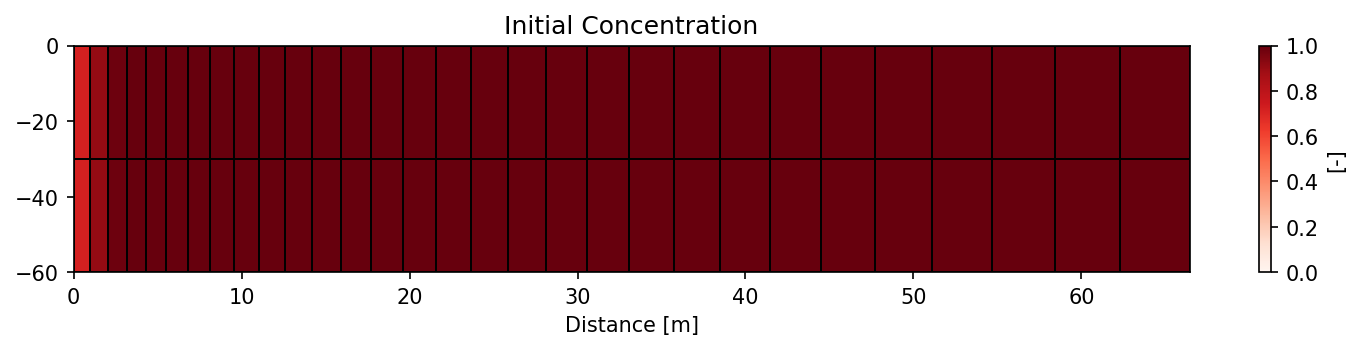

[1. 1.]


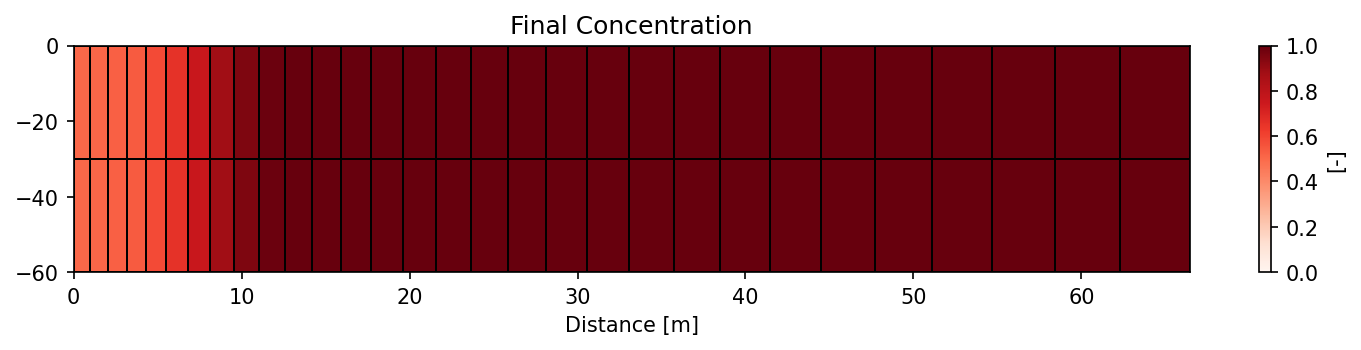

[0.5044667 0.5044668]


In [502]:
plot_2d(np.squeeze(conc[2,:,:,:30]), rj_edges[:31], -ri_edges,  colorbar_label='[-]', cmap='Reds', title='Initial Concentration', clim=[0, 1])
print(conc[0,:,0,0])
plot_2d(np.squeeze(conc[-1,:,:,:30]), rj_edges[:31], -ri_edges,  colorbar_label='[-]', cmap='Reds', title='Final Concentration', clim=[0, 1])
print(conc[-1,:,0,0])

After each plot above the layer concentration at the left boundary is printed. Are these values what you would expect?

Let's plot some concentration histories at a few different times. To look at these profiles in more detail.

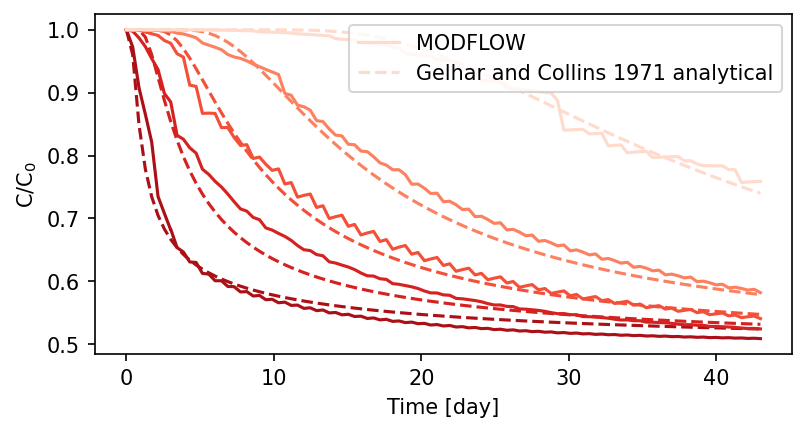

6.22773015499115


In [503]:
# Number of differnt cells to plot breakthrough curves
n =5
color = plt.cm.Reds_r(np.linspace(0, 1, n+3))

# Generate figure
plt.figure(figsize=(6, 3),dpi=150)
# variable to track least absolute deviation
error = 0
# loop through cells
for i in range(1, n):
    # calculate analytical solution as a function of time
    Ct_analytical = ADE_radial_fun(times, rj[i], Q, model_thickness, porosity, alpha_L, 0, pi, C0=1, C_inj=C_inj)
    # plot analytical and numerical solutions
    plt.plot(times, np.squeeze(conc[:,1,0,i]), color = color[i])
    plt.plot(times, Ct_analytical, '--', color=color[i])
    # calculate numerical error
    sum_error = np.sum(np.abs(conc[:,1,0,i] - Ct_analytical))
    error += sum_error

# plot one more line and label the lines for the legend
Ct_analytical = ADE_radial_fun(times, rj[n+1], Q, model_thickness, porosity, alpha_L, 0, pi, C0=1, C_inj=C_inj)
plt.plot(times, np.squeeze(conc[:,1,0,n+1]), color = color[n+1], label = 'MODFLOW')
plt.plot(times, Ct_analytical, '--', color=color[n+1], label = 'Gelhar and Collins 1971 analytical')
plt.xlabel('Time [day]')
plt.ylabel(r'C/C$_0$')
plt.legend()
plt.show()
print(error)

Calculating and comparing this numerical error can be useful for determining the influence of different model discretization, Peclet numbers, and mixelm options for the advection solution.

Finally, let's plot a concentration profile to compare the numerical and analytical solutions in space.

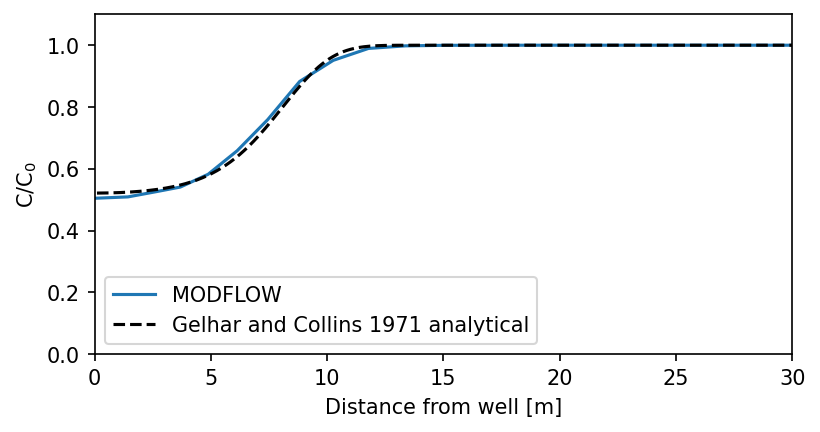

In [504]:
# Discretize the analytical solution a little finer than the numerical grid cells
rj_analytical = np.linspace(0.1, 50, 1000)
C_analytical = ADE_radial_fun(times[-1], rj_analytical, Q, model_thickness, porosity, alpha_L, 0, pi, C0=1, C_inj=C_inj)

# Generate plot
plt.figure(figsize=(6, 3),dpi=150)
plt.plot(rj, np.squeeze(np.mean(conc[-1,:,0,:], axis=0)), label = 'MODFLOW')
plt.plot(rj_analytical, C_analytical, '--k', label = 'Gelhar and Collins 1971 analytical')
# plt.xscale('log')
plt.xlim([0, 30])
plt.ylim([0, 1.1])
plt.xlabel('Distance from well [m]')
plt.ylabel(r'C/C$_0$')
plt.legend()
plt.show()

Looks pretty good! 

## Activity:
Using a combination of analytical solutions and moment analysis, determine how the numerical model error changes with different solution methods `mixelm`, model discretization, and different injection rate conditions.

In [505]:
# RUN model! Note that if model is steady state then SS and SY can just be set to 0
# heads, htimes, conc, times = radial_model_2D(dirname, perlen_mt, ri_edges, HK, POR, VKA, 0, 0, AL, Q, C_inj, Ci_layer, nprs=100, mixelm=1)
